In [1]:
import tensorflow as tf
import numpy as np

from sklearn.model_selection import train_test_split

import matplotlib as mpl
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt

import time
import re
import os
import io


# from tqdm import tqdm_notebook 
from tqdm.notebook import tqdm 
import random

import sentencepiece as spm
from konlpy.tag import Mecab
from nltk.translate.bleu_score import sentence_bleu
from nltk.translate.bleu_score import SmoothingFunction

# Step 1. 데이터 다운로드
   

In [2]:
# train data load
data_dir = os.getenv('HOME')+'/aiffel/data'
kor_path = data_dir+"/korean-english-park.train.ko"
eng_path = data_dir+"/korean-english-park.train.en"

# test data loading
kor_path_test =data_dir+"/korean-english-park.test.ko"
eng_path_test =data_dir+"/korean-english-park.test.en"

# Step 2. 데이터 정제 및 토큰화

In [3]:
# Train 데이터 정제 및 토큰화
def clean_corpus(kor_path, eng_path):
    with open(eng_path, "r") as f: eng = f.read().splitlines()
    with open(kor_path, "r") as f: kor = f.read().splitlines()

    assert len(kor) == len(eng) # kor, eng가 같은 갯수라는 것을 검증받기 위해 적용

    cleaned_corpus = list(set(zip(eng, kor)))  # 중복된 데이터 제거
    
    return cleaned_corpus

cleaned_corpus = clean_corpus(eng_path, kor_path)
len(cleaned_corpus)

78968

In [4]:
# Test 데이터 정제 및 토큰화
def clean_corpus_test(kor_path_test, eng_path_test):
    with open(eng_path_test, "r") as f: eng_test = f.read().splitlines()
    with open(kor_path_test, "r") as f: kor_test = f.read().splitlines()

    assert len(kor_test) == len(eng_test) # kor, eng가 같은 갯수라는 것을 검증받기 위해 적용

    cleaned_corpus_test = list(set(zip(eng_test, kor_test)))  # 중복된 데이터 제거
    
    return cleaned_corpus_test

cleaned_corpus_test = clean_corpus_test(eng_path_test, kor_path_test)
len(cleaned_corpus_test)

1996

In [6]:
cleaned_corpus[:2]

[('슈마허는 이러한 이야기를 서로 해야 한다고 생각하게 됐다.',
  'Schumacher, the sales account manager from San Francisco, would have appreciated having that conversation.'),
 ('GNP to sue former senior official of the spy agency ˝한나라당, 전 국정원 간부 고발 예정˝\xa0 \xa0 \xa02007.10',
  'On Wednesday, the government announced the latest steps in its bid to achieve the financial hub plan, including providing tax breaks to promote mergers and acquisitions (M&As) between financial companies.')]

In [7]:
cleaned_corpus_test[:2]

[('첸 젱핑은 독극물을 사용한 죄로 난징 제1 중재 인민 법원에 의해 선고를 받았다고 관영 신화 통신이 보도했다.',
  "by the Nanjing No.1 Intermediate People's Court for usage of a dangerous substance, the official Xinhua news agency reported."),
 ('만 대변인은 피셔 보엘 위원 앞으로 규칙적으로 보내진 대부분 우유는 배달 중에 상했고 일부는 우유곽이 열려 있었다고 말했다.',
  'Most of the milk sent by regular mail and addressed to Fischer Boel had spoiled in transit, and some of the cartons had burst open, he said.')]

In [8]:
# cleaned_corpus+=cleaned_corpus_test

In [9]:
len(cleaned_corpus)

78968

In [10]:
# 1. 모든 입력을 소문자로 변환합니다.
# 2. 알파벳, 문장부호, 한글만 남기고 모두 제거합니다.
# 3. 문장부호 양옆에 공백을 추가합니다.
# 4. 문장 앞뒤의 불필요한 공백을 제거합니다.

def preprocess_sentence(sentence):

    sentence = sentence.lower() #1
    sentence = re.sub(r"[^a-zA-Z가-힣?.!,]+", " ", sentence) #2
    sentence = re.sub(r"([?.!,])", r" \1 ", sentence) #3
    sentence = re.sub(r'[" "]+', " ", sentence) #4
    
    return sentence

In [11]:
# 한글 말뭉치 kor_corpus 와 영문 말뭉치 eng_corpus 를 각각 분리한 후, 정제하여 토큰화를 진행
# 최종적으로 ko_tokenizer 과 en_tokenizer 를 얻기
# en_tokenizer에는 set_encode_extra_options("bos:eos") 함수를 실행해 타겟 입력이 문장의 시작 토큰과 끝 토큰을 포함할 수 있게
# 단어 사전을 매개변수로 받아 원하는 크기의 사전을 정의할 수 있게 합니다. (기본: 20,000)
# 학습 후 저장된 model 파일을 SentencePieceProcessor() 클래스에 Load()한 후 반환합니다.
# 특수 토큰의 인덱스를 아래와 동일하게 지정합니다.
# <PAD> : 0 / <BOS> : 1 / <EOS> : 2 / <UNK> : 3

# Sentencepiece를 활용하여 학습한 tokenizer를 생성
def generate_tokenizer(corpus, vocab_size, lang="en", pad_id=0, bos_id=1, eos_id=2, unk_id=3):

    temp_file = os.getenv('HOME') + f'/aiffel/data/corpus_{lang}.txt'     # corpus를 받아 txt파일로 저장
    
    with open(temp_file, 'w') as f:
        for row in corpus:
            f.write(str(row) + '\n')
    
    # Sentencepiece를 이용해 
    spm.SentencePieceTrainer.Train(
        f'--input={temp_file} --pad_id={pad_id} --bos_id={bos_id} --eos_id={eos_id} \
        --unk_id={unk_id} --model_prefix=spm{lang}_r2 --vocab_size={vocab_size}'   # model_r1
    )
    tokenizer = spm.SentencePieceProcessor()
    tokenizer.Load(f'spm{lang}_r2.model') # model_r1

    return tokenizer

In [15]:
# Train data
SRC_VOCAB_SIZE = TGT_VOCAB_SIZE = 25000

eng_corpus = []
kor_corpus = []

for pair in cleaned_corpus:
    k, e = pair[0], pair[1]
    # kor, eng 나눠서 데이터 정제 후 분리
    kor_corpus.append(preprocess_sentence(k))
    eng_corpus.append(preprocess_sentence(e))

en_tokenizer = generate_tokenizer(eng_corpus, SRC_VOCAB_SIZE, "en")
ko_tokenizer = generate_tokenizer(kor_corpus, TGT_VOCAB_SIZE, "ko")
ko_tokenizer.set_encode_extra_options("bos:eos")

sentencepiece_trainer.cc(177) LOG(INFO) Running command: --input=/aiffel/aiffel/data/corpus_en.txt --pad_id=0 --bos_id=1 --eos_id=2         --unk_id=3 --model_prefix=spmen_r2 --vocab_size=25000
sentencepiece_trainer.cc(77) LOG(INFO) Starts training with : 
trainer_spec {
  input: /aiffel/aiffel/data/corpus_en.txt
  input_format: 
  model_prefix: spmen_r2
  model_type: UNIGRAM
  vocab_size: 25000
  self_test_sample_size: 0
  character_coverage: 0.9995
  input_sentence_size: 0
  shuffle_input_sentence: 1
  seed_sentencepiece_size: 1000000
  shrinking_factor: 0.75
  max_sentence_length: 4192
  num_threads: 16
  num_sub_iterations: 2
  max_sentencepiece_length: 16
  split_by_unicode_script: 1
  split_by_number: 1
  split_by_whitespace: 1
  split_digits: 0
  treat_whitespace_as_suffix: 0
  allow_whitespace_only_pieces: 0
  required_chars: 
  byte_fallback: 0
  vocabulary_output_piece_score: 1
  train_extremely_large_corpus: 0
  hard_vocab_limit: 1
  use_all_vocab: 0
  unk_id: 3
  bos_id: 1


True

_tokens/piece=7.52486
unigram_model_trainer.cc(505) LOG(INFO) EM sub_iter=0 size=39588 obj=11.5538 num_tokens=420665 num_tokens/piece=10.6261
unigram_model_trainer.cc(505) LOG(INFO) EM sub_iter=1 size=39588 obj=11.5172 num_tokens=420679 num_tokens/piece=10.6264
unigram_model_trainer.cc(505) LOG(INFO) EM sub_iter=0 size=29691 obj=11.7107 num_tokens=446988 num_tokens/piece=15.0547
unigram_model_trainer.cc(505) LOG(INFO) EM sub_iter=1 size=29691 obj=11.6693 num_tokens=446992 num_tokens/piece=15.0548
unigram_model_trainer.cc(505) LOG(INFO) EM sub_iter=0 size=27500 obj=11.7272 num_tokens=453579 num_tokens/piece=16.4938
unigram_model_trainer.cc(505) LOG(INFO) EM sub_iter=1 size=27500 obj=11.7164 num_tokens=453580 num_tokens/piece=16.4938
trainer_interface.cc(615) LOG(INFO) Saving model: spmko_r2.model
trainer_interface.cc(626) LOG(INFO) Saving vocabs: spmko_r2.vocab


In [17]:
print('eng_corpus: ', eng_corpus[100])
print('kor_corpus: ', kor_corpus[100])

eng_corpus:  the ferry s manifest showed passengers and crew were on board the boat , but one official said the real number was higher . 
kor_corpus:  여객선 승객명단을 보면 명의 승객과 승무원이 타고 있었으나 한 당국자에 의하면 실제 인원은 더 많을 것으로 여겨진다 . 


In [18]:
# Test data
SRC_VOCAB_SIZE = TGT_VOCAB_SIZE = 25000

eng_corpus_test = []
kor_corpus_test = []

for pair in cleaned_corpus_test:
    k, e = pair[0], pair[1]
    # kor, eng 나눠서 데이터 정제 후 분리
    kor_corpus_test.append(preprocess_sentence(k))
    eng_corpus_test.append(preprocess_sentence(e))

# en_test_tokenizer = generate_tokenizer(eng_corpus, SRC_VOCAB_SIZE, "en")
# ko_test_tokenizer = generate_tokenizer(kor_corpus, TGT_VOCAB_SIZE, "ko")
# ko_test_tokenizer.set_encode_extra_options("bos:eos")

In [19]:
print('eng_corpus_test: ', eng_corpus_test[100])
print('kor_corpus_test: ', kor_corpus_test[100])

eng_corpus_test:   cristiano will begin his convalescence under the direction of club medical staff and an estimation of his return to full fitness will be possible following review by the specialist in one month . 
kor_corpus_test:  맨유는 또 호날두는 의료진의 보호 아래 회복기를 가질 것 이라며 전문가들은 호날두가 한달 후에 건강한 모습으로 돌아온다고 말했다 고 전했다 . 


문장의 최단 길이: 1
문장의 최장 길이: 611
문장의 평균 길이: 135


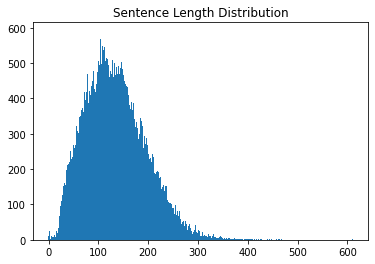

In [20]:
# eng_corpus 통계

min_len = 999
max_len = 0
sum_len = 0


for sen in eng_corpus:
    length = len(sen)
    if min_len > length: min_len = length
    if max_len < length: max_len = length
    sum_len += length

print("문장의 최단 길이:", min_len)
print("문장의 최장 길이:", max_len)
print("문장의 평균 길이:", sum_len // len(eng_corpus))

sentence_length = np.zeros((max_len), dtype=int)

#총 max_len의 배열을 만든 후, raw 문장을 돌면서 각 문장별 길이를 sentence_length의 len(sen) 인덱스마다  계속 더해가면서 counting
for sen in eng_corpus:
    sentence_length[len(sen)-1] += 1

plt.bar(range(max_len), sentence_length, width=1.0)
plt.title("Sentence Length Distribution")
plt.show()

문장의 최단 길이: 1
문장의 최장 길이: 331
문장의 평균 길이: 64


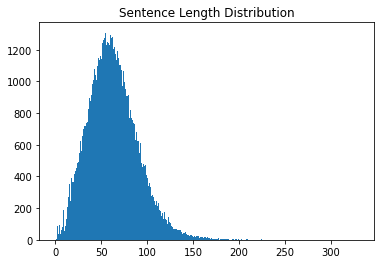

In [20]:
# kor_corpus 통계

min_len = 999
max_len = 0
sum_len = 0


for sen in kor_corpus:
    length = len(sen)
    if min_len > length: min_len = length
    if max_len < length: max_len = length
    sum_len += length

print("문장의 최단 길이:", min_len)
print("문장의 최장 길이:", max_len)
print("문장의 평균 길이:", sum_len // len(kor_corpus))

sentence_length = np.zeros((max_len), dtype=int)

#총 max_len의 배열을 만든 후, raw 문장을 돌면서 각 문장별 길이를 sentence_length의 len(sen) 인덱스마다  계속 더해가면서 counting
for sen in kor_corpus:
    sentence_length[len(sen)-1] += 1

plt.bar(range(max_len), sentence_length, width=1.0)
plt.title("Sentence Length Distribution")
plt.show()

In [21]:
# max_tokens = np.mean(num_tokens) + 2.5 * np.std(num_tokens)
# maxlen = int(max_tokens)
# print('pad_sequences maxlen : ', maxlen)
# print(f'전체 문장의 {np.sum(num_tokens < max_tokens) / len(num_tokens)*100}%가 maxlen 설정값 이내에 포함됩니다.')

In [24]:
# 토크나이저를 활용해 토큰의 길이가 50 이하인 데이터를 선별하여 src_corpus 와 tgt_corpus 를 각각 구축하고, 텐서 enc_train 과 dec_train 으로 변환
src_corpus = [] #영어
tgt_corpus = [] #한글

assert len(kor_corpus) == len(eng_corpus)

# 토큰의 길이가 xxx 이하인 문장만 남깁니다. 
for idx in tqdm(range(len(kor_corpus))):
    src = en_tokenizer.EncodeAsIds(eng_corpus[idx])
    tgt = ko_tokenizer.EncodeAsIds(kor_corpus[idx])
    
    if len(src) <= 120 and len(tgt) <= 100: 
        src_corpus.append(src)
        tgt_corpus.append(tgt)

# 패딩처리를 완료하여 학습용 데이터를 완성합니다. 
enc_train = tf.keras.preprocessing.sequence.pad_sequences(src_corpus, padding='post')
dec_train = tf.keras.preprocessing.sequence.pad_sequences(tgt_corpus, padding='post')

  0%|          | 0/78968 [00:00<?, ?it/s]

In [23]:
# # 훈련 데이터와 검증 데이터로 분리하기
# enc_train, enc_val, dec_train, dec_val = train_test_split(enc_data, dec_data, test_size=0.05)

In [25]:
# enc, dec 의 seq_length는 달라도 상관없음.
print(enc_train.shape)
print(dec_train.shape)
# print(enc_val.shape)
# print(dec_val.shape)

(78967, 116)
(78967, 95)


# Step 3. 모델설계

## Positional Encoding

In [26]:
# pos - 단어가 위치한 Time-step(각각의 토큰의 위치정보값이며 정수값을 의미)
# d_model - 모델의 Embedding 차원 수
# i - Encoding차원의 index

def positional_encoding(pos, d_model):
    def cal_angle(position, i):
        return position / np.power(10000, int(i)/d_model)  # np.power(a,b) > a^b(제곱)
    
    def get_posi_angle_vec(position):
        return [cal_angle(position, i) for i in range(d_model)]
    
    sinusoid_table = np.array([get_posi_angle_vec(pos_i) for pos_i in range(pos)])
    
    # 배열의 짝수 인덱스(2i)에는 사인 함수 적용
    sinusoid_table[:, 0::2] = np.sin(sinusoid_table[:, 0::2])
    # 배열의 홀수 인덱스(2i+1)에는 코사인 함수 적용
    sinusoid_table[:, 1::2] = np.cos(sinusoid_table[:, 1::2])
    
    return sinusoid_table

## Multi-Head Attention

In [27]:
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model
        
        self.depth = d_model // self.num_heads
        
        self.W_q = tf.keras.layers.Dense(d_model)  # Linear Layer
        self.W_k = tf.keras.layers.Dense(d_model)
        self.W_v = tf.keras.layers.Dense(d_model)
        
        self.linear = tf.keras.layers.Dense(d_model)
        
    def scaled_dot_product_attention(self, Q, K, V, mask):
        d_k = tf.cast(K.shape[-1], tf.float32)
        
        # Scaled QK 값 구하기
        QK = tf.matmul(Q, K, transpose_b=True)
        scaled_qk = QK / tf.math.sqrt(d_k)
        
        if mask is not None:
            scaled_qk += (mask * -1e9)
        
        # 1. Attention Weights 값 구하기 -> attentions
        attentions = tf.nn.softmax(scaled_qk, axis=-1)
        # 2. Attention 값을 V에 곱하기 -> out
        out = tf.matmul(attentions, V)
        return out, attentions
    
    def split_heads(self, x):
        """
        Embedding된 입력을 head의 수로 분할하는 함수
        
        x: [ batch x length x emb ]
        return: [ batch x length x heads x self.depth ]
        """
        bsz = x.shape[0]
        split_x = tf.reshape(x, (bsz, -1, self.num_heads, self.depth))
        split_x = tf.transpose(split_x, perm=[0, 2, 1, 3])
        return split_x
    
    def combine_heads(self, x):
        """
        분할된 Embedding을 하나로 결합하는 함수
        
        x: [ batch x length x heads x self.depth ]
        return: [ batch x length x emb ]
        """
        bsz = x.shape[0]
        combined_x = tf.transpose(x, perm=[0, 2, 1, 3])
        combined_x = tf.reshape(combined_x, (bsz, -1, self.d_model))
        return combined_x
    
    def call(self, Q, K, V, mask):
        """
        Step 1: Linear_in(Q, K, V) -> WQ, WK, WV
        Step 2: Split Heads(WQ, WK, WV) -> WQ_split, WK_split, WV_split
        Step 3: Scaled Dot Product Attention(WQ_split, WK_split, WV_split)
                 -> out, attention_weights
        Step 4: Combine Heads(out) -> out
        Step 5: Linear_out(out) -> out
        """
        WQ = self.W_q(Q)
        WK = self.W_k(K)
        WV = self.W_v(V)
        
        WQ_splits = self.split_heads(WQ)
        WK_splits = self.split_heads(WK)
        WV_splits = self.split_heads(WV)
        
        out, attention_weights = self.scaled_dot_product_attention(
            WQ_splits, WK_splits, WV_splits, mask
        )
        
        out = self.combine_heads(out)
        out = self.linear(out)
        
        return out, attention_weights

## Position-wise Feed-Forward Network

In [28]:
class PoswiseFeedForwardNet(tf.keras.layers.Layer):
    def __init__(self, d_model, d_ff):
        super(PoswiseFeedForwardNet, self).__init__()
        self.w_1 = tf.keras.layers.Dense(d_ff, activation='relu')
        self.w_2 = tf.keras.layers.Dense(d_model)

    def call(self, x):
        out = self.w_1(x)
        out = self.w_2(out)
            
        return out

print("슝=3")

슝=3


## Encoder 레이어 구현하기

In [29]:
class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, n_heads, d_ff, dropout):
        super(EncoderLayer, self).__init__()
        self.enc_self_attn = MultiHeadAttention(d_model, n_heads)
        self.ffn = PoswiseFeedForwardNet(d_model, d_ff)
        
        self.norm_1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        
        self.do = tf.keras.layers.Dropout(dropout)
        
    def call(self, x, mask):
        # Multi-Head Attention
        residual = x
        out = self.norm_1(x)
        out, enc_attn = self.enc_self_attn(out, out, out, mask)
        out = self.do(out)
        out += residual*1 
        
        # Position-Wise Feed Forward Network
        residual = out
        out = self.norm_2(out)
        out = self.ffn(out)
        out = self.do(out)
        out += residual*1 
        
        return out, enc_attn

## Decoder 레이어 구현하기

In [30]:
class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, d_ff, dropout):
        super(DecoderLayer, self).__init__()

        self.dec_self_attn = MultiHeadAttention(d_model, num_heads)
        self.enc_dec_attn = MultiHeadAttention(d_model, num_heads)

        self.ffn = PoswiseFeedForwardNet(d_model, d_ff)

        self.norm_1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.do = tf.keras.layers.Dropout(dropout)
        
    def call(self, x, enc_out, causality_mask, padding_mask):
        # Masked Multi-Head Attention
        residual = x
        out = self.norm_1(x)
        #out, dec_attn = self.dec_self_attn(out, out, out, causality_mask)
        out, dec_attn = self.dec_self_attn(out, out, out, padding_mask)
        out = self.do(out)
        out += residual
        
        # Multi-Head Attention
        residual = out
        out = self.norm_2(out)
        #out, dec_enc_attn = self.enc_dec_attn(out, enc_out, enc_out, padding_mask)
        out, dec_enc_attn = self.enc_dec_attn(out, enc_out, enc_out, causality_mask)
        out = self.do(out)
        out += residual

        # Position-Wise Feed Forward Network
        residual = out
        out = self.norm_3(out)
        out = self.ffn(out)
        out = self.do(out)
        out += residual

        return out, dec_attn, dec_enc_attn

## Encoder와 Decoder 클래스를 정의

In [31]:
class Encoder(tf.keras.Model):
    def __init__(self, n_layers, d_model, n_heads, d_ff, dropout):
        super(Encoder, self).__init__()
        self.n_layers = n_layers
        self.enc_layers = [EncoderLayer(d_model, n_heads, d_ff, dropout) for _ in range(n_layers)]
        self.do = tf.keras.layers.Dropout(dropout)
        
    def call(self, x, mask):
        out = x
        enc_attns = list()
        for i in range(self.n_layers):
            out, enc_attn = self.enc_layers[i](out, mask)
            enc_attns.append(enc_attn)
            
        return out, enc_attns

In [32]:
class Decoder(tf.keras.Model):
    def __init__(self, n_layers, d_model, n_heads, d_ff, dropout):
        super(Decoder, self).__init__()
        self.n_layers = n_layers
        self.dec_layers = [DecoderLayer(d_model, n_heads, d_ff, dropout) for _ in range(n_layers)]
        
    def call(self, x, enc_out, causality_mask, padding_mask):
        out = x
        dec_attns = list()
        dec_enc_attns = list()
        for i in range(self.n_layers):
            out, dec_attn, dec_enc_attn = self.dec_layers[i](out, enc_out, causality_mask, padding_mask)
            dec_attns.append(dec_attn)
            dec_enc_attns.append(dec_enc_attn)
        
        return out, dec_attns, dec_enc_attns

## Transformer 완성하기

In [33]:
class Transformer(tf.keras.Model):
    def __init__(self, n_layers, d_model, n_heads, d_ff, src_vocab_size, tgt_vocab_size,
                 pos_len, dropout=0.2, shared=True):
        super(Transformer, self).__init__()
        self.d_model = tf.cast(d_model, tf.float32)
        
        # 1. Embedding Layer 정의
        self.enc_emb = tf.keras.layers.Embedding(src_vocab_size, d_model)
        self.dec_emb = tf.keras.layers.Embedding(tgt_vocab_size, d_model)
        
        # 2. Positional Encoding 정의
        self.pos_encoding = positional_encoding(pos_len, d_model)
        # 6. Dropout 정의
        self.do = tf.keras.layers.Dropout(dropout)
        
        # 3. Encoder / Decoder 정의
        self.encoder = Encoder(n_layers, d_model, n_heads, d_ff, dropout)
        self.decoder = Decoder(n_layers, d_model, n_heads, d_ff, dropout)
        
        # 4. Output Linear 정의
        self.fc = tf.keras.layers.Dense(tgt_vocab_size)
        
        # 5. Shared Weights
        self.shared = shared
        
        if shared:
            self.fc.set_weights(tf.transpose(self.dec_emb.weights))
        
        
    def embedding(self, emb, x):
        """
        입력된 정수 배열을 Embedding + Pos Encoding
        + Shared일 경우 Scaling 작업 포함

        x: [ batch x length ]
        return: [ batch x length x emb ]
        """
        seq_len = x.shape[1]
        out = emb(x)
        
        if self.shared:
            out *= tf.math.sqrt(self.d_model)
        
        out += self.pos_encoding[np.newaxis, ...][:, :seq_len, :]
        out = self.do(out)
        
        return out
    
    def call(self, enc_in, dec_in, enc_mask, causality_mask, dec_mask):
        # Step 1: Embedding(enc_in, dec_in) -> enc_in, dec_in
        enc_in = self.embedding(self.enc_emb, enc_in)
        dec_in = self.embedding(self.dec_emb, dec_in)
        
        # Step 2: Encoder(enc_in, enc_mask) -> enc_out, enc_attns
        enc_out, enc_attns = self.encoder(enc_in, enc_mask)

        # Step 3: Decoder(dec_in, enc_out, mask) -> dec_out, dec_attns, dec_enc_attns
        dec_out, dec_attns, dec_enc_attns = self.decoder(dec_in, enc_out, causality_mask, dec_mask)
        
        # Step 4: Out Linear(dec_out) -> logits
        logits = self.fc(dec_out)
        
        return logits, enc_attns, dec_attns, dec_enc_attns
    

## Mask

In [34]:
# Attention을 할 때에 <PAD> 토큰에도 Attention을 주는 것을 방지해 주는 역할
def generate_padding_mask(seq):
    seq = tf.cast(tf.math.equal(seq, 0), tf.float32)
    return seq[:, tf.newaxis, tf.newaxis, :]

def generate_causality_mask(src_len, tgt_len):
    mask = 1 - np.cumsum(np.eye(src_len, tgt_len), 0)
    return tf.cast(mask, tf.float32)

def generate_masks(src, tgt):
    enc_mask = generate_padding_mask(src)
    dec_mask = generate_padding_mask(tgt)

    dec_enc_causality_mask = generate_causality_mask(tgt.shape[1], src.shape[1])
    dec_enc_mask = tf.maximum(enc_mask, dec_enc_causality_mask)

    dec_causality_mask = generate_causality_mask(tgt.shape[1], tgt.shape[1])
    dec_mask = tf.maximum(dec_mask, dec_causality_mask)

    return enc_mask, dec_enc_mask, dec_mask

# Step 4. 훈련하기

In [35]:
transformer = Transformer(
    n_layers=6,
    d_model=512,
    n_heads=8,
    d_ff=2048,
    src_vocab_size=SRC_VOCAB_SIZE,
    tgt_vocab_size=TGT_VOCAB_SIZE,
    pos_len=200,
    dropout=0.2,
    shared=True
)

##  Learning Rate Scheduler를 선언하고, 이를 포함하는 Adam Optimizer를 선언

In [36]:
class LearningRateScheduler(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super(LearningRateScheduler, self).__init__()
        self.d_model = d_model
        self.warmup_steps = warmup_steps
    
    def __call__(self, step):
        arg1 = step ** -0.5
        arg2 = step * (self.warmup_steps ** -1.5)
        
        return (self.d_model ** -0.5) * tf.math.minimum(arg1, arg2)

In [37]:
learning_rate = LearningRateScheduler(512)
optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

## Loss 함수를 정의

In [38]:
# Loss 함수 정의
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    # Masking 되지 않은 입력의 개수로 Scaling하는 과정
    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_sum(loss_)/tf.reduce_sum(mask)

## train_step 함수를 정의

In [39]:
@tf.function()
def train_step(src, tgt, model, optimizer):
    gold = tgt[:, 1:]
        
    enc_mask, dec_enc_mask, dec_mask = generate_masks(src, tgt)

    # 계산된 loss에 tf.GradientTape()를 적용해 학습을 진행합니다.
    with tf.GradientTape() as tape:
        predictions, enc_attns, dec_attns, dec_enc_attns = model(src, tgt, enc_mask, dec_enc_mask, dec_mask)
        loss = loss_function(gold, predictions[:, :-1])

    # 최종적으로 optimizer.apply_gradients()가 사용됩니다. 
    gradients = tape.gradient(loss, model.trainable_variables)    
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    
    return loss, enc_attns, dec_attns, dec_enc_attns

In [40]:
ckpt = tf.train.Checkpoint(step = tf.Variable(1), optimizer = optimizer , transformer = transformer)
manager = tf.train.CheckpointManager(ckpt, './tf_ckpts_gd12_r1',max_to_keep=2)

## Attention 시각화 함수

In [41]:
# Attention 시각화 함수
def visualize_attention(src, tgt, enc_attns, dec_attns, dec_enc_attns):
    def draw(data, ax, x="auto", y="auto"):
        import seaborn
        seaborn.heatmap(data, 
                        square=True,
                        vmin=0.0, vmax=1.0, 
                        cbar=False, ax=ax,
                        xticklabels=x,
                        yticklabels=y)
        
    for layer in range(0, 2, 1):
        fig, axs = plt.subplots(1, 4, figsize=(20, 10))
        print("Encoder Layer", layer + 1)
        for h in range(4):
            draw(enc_attns[layer][0, h, :len(src), :len(src)], axs[h], src, src)
        plt.show()
        
    for layer in range(0, 2, 1):
        fig, axs = plt.subplots(1, 4, figsize=(20, 10))
        print("Decoder Self Layer", layer+1)
        for h in range(4):
            draw(dec_attns[layer][0, h, :len(tgt), :len(tgt)], axs[h], tgt, tgt)
        plt.show()

        print("Decoder Src Layer", layer+1)
        fig, axs = plt.subplots(1, 4, figsize=(20, 10))
        for h in range(4):
            draw(dec_enc_attns[layer][0, h, :len(tgt), :len(src)], axs[h], src, tgt)
        plt.show()

## 번역생성함수

In [42]:
# 번역 생성 함수
def evaluate(sentence, model, src_tokenizer, tgt_tokenizer):
    sentence = preprocess_sentence(sentence)
    pieces = src_tokenizer.encode_as_pieces(sentence)
    tokens = src_tokenizer.encode_as_ids(sentence)

    _input = tf.keras.preprocessing.sequence.pad_sequences([tokens], maxlen=enc_train.shape[-1], padding='post')

    ids = []
    output = tf.expand_dims([tgt_tokenizer.bos_id()], 0)
    for i in range(dec_train.shape[-1]):
        enc_padding_mask, combined_mask, dec_padding_mask = generate_masks(_input, output)
        

        predictions, enc_attns, dec_attns, dec_enc_attns = model(_input, output, enc_padding_mask, combined_mask, dec_padding_mask)
        
        predicted_id = tf.argmax(tf.math.softmax(predictions, axis=-1)[0, -1]).numpy().item()
        if tgt_tokenizer.eos_id() == predicted_id:
            result = tgt_tokenizer.decode_ids(ids)
            return pieces, result, enc_attns, dec_attns, dec_enc_attns

        ids.append(predicted_id)
        output = tf.concat([output, tf.expand_dims([predicted_id], 0)], axis=-1)
    result = tgt_tokenizer.decode_ids(ids)
    return pieces, result, enc_attns, dec_attns, dec_enc_attns

In [43]:
# 번역 생성 및 Attention 시각화 결합
def translate(sentence, model, src_tokenizer, tgt_tokenizer, plot_attention=False):
    pieces, result, enc_attns, dec_attns, dec_enc_attns = evaluate(sentence, model, src_tokenizer, tgt_tokenizer)
    
    print('Input: %s' % (sentence))
    print('Predicted translation: {}'.format(result))

    if plot_attention:
        visualize_attention(pieces, result.split(), enc_attns, dec_attns, dec_enc_attns)
        
    return result

In [44]:
examples = [
    "How was your day? I was the best.",
    "Take your time, please.",
    "I’m about to leave. Please hold for a moment.",
    "Have you heard of it?"
]

## 학습

In [45]:
# 학습
EPOCHS = 6
BATCH_SIZE = 64

def train_and_checkpoint(transformer, manager, EPOCHS):
    ckpt.restore(manager.latest_checkpoint)
    if manager.latest_checkpoint:
        print("Restored from {}".format(manager.latest_checkpoint))
    
    else:
        print("Initializing from scratch.")


    for epoch in range(EPOCHS):
        total_loss = 0

        idx_list = list(range(0, enc_train.shape[0], BATCH_SIZE))
        random.shuffle(idx_list)
        t = tqdm(idx_list)

        for (batch, idx) in enumerate(t):
            batch_loss, enc_attns, dec_attns, dec_enc_attns = train_step(enc_train[idx:idx+BATCH_SIZE],
                                                                         dec_train[idx:idx+BATCH_SIZE],
                                                                         transformer,
                                                                         optimizer)

            total_loss += batch_loss

            t.set_description_str('Epoch %2d' % (epoch + 1))
            t.set_postfix_str('Loss %.4f' % (total_loss.numpy() / (batch + 1)))
      
      
        # 매 Epoch 마다 제시된 예문에 대한 번역 생성
        for example in examples:
            translate(example, transformer, en_tokenizer, ko_tokenizer)
            
 
        if int(ckpt.step) % 2 == 0:
            save_path = manager.save()
            print("Saved checkpoint for step {}: {}".format(int(ckpt.step), save_path))

In [46]:
train_and_checkpoint(transformer, manager, EPOCHS )

Initializing from scratch.


  0%|          | 0/1234 [00:00<?, ?it/s]

Input: How was your day? I was the best.
Predicted translation: 그는 또 다른 사람들의 이야기를 통해 우리가 될 것이다 .
Input: Take your time, please.
Predicted translation: 그는 또 다른 사람들은 자신의 이야기를 위한 것이다 .
Input: I’m about to leave. Please hold for a moment.
Predicted translation: 그는 또 다른 사람들은 더 많은 사람들이 더 많은 것을 알고 있다 .
Input: Have you heard of it?
Predicted translation: 그는 우리가 우리가 ?


  0%|          | 0/1234 [00:00<?, ?it/s]

Input: How was your day? I was the best.
Predicted translation: 그는 또 얼마나 잘 알고 있다 .
Input: Take your time, please.
Predicted translation: 다음 보기
Input: I’m about to leave. Please hold for a moment.
Predicted translation: 그는 또 나는 자신의 집을 찾는 것을 목격했다 며 나는 그가 자신의 집을 받을 수 있다 고 말했다 .
Input: Have you heard of it?
Predicted translation: 여러분은 동영상이 언제 ?


  0%|          | 0/1234 [00:00<?, ?it/s]

Input: How was your day? I was the best.
Predicted translation: 그는 이틀 동안 얼마나 많은 순간을 날랐다 며 그녀가 어떻게 기억됐는지는 말하지 않았다 고 말했다 .
Input: Take your time, please.
Predicted translation: 당신에게 당신의 시간을 보내야 할 것
Input: I’m about to leave. Please hold for a moment.
Predicted translation: 그는 내가 내가 난 후 다시한번 다시한번 기도할 것 이라며 난 후 다시한번 내가를 할 것 이라며 난 순간 이라고 말했다 .
Input: Have you heard of it?
Predicted translation: 노래는 소리 !


  0%|          | 0/1234 [00:00<?, ?it/s]

Input: How was your day? I was the best.
Predicted translation: 얼마나 날지는 기억이 날이었다 .
Input: Take your time, please.
Predicted translation: 당신의 시간을 보내는
Input: I’m about to leave. Please hold for a moment.
Predicted translation: 나는 나는 나는 나는 그들이 원하는 사람들을 위해 줄을 서서히 걸었다 .
Input: Have you heard of it?
Predicted translation:  ⁇  소리는 소리 ?


  0%|          | 0/1234 [00:00<?, ?it/s]

Input: How was your day? I was the best.
Predicted translation: 그는 어떻게 대처할 지에 대해 궁금해 하고 있는지 모르겠다 고 말했다 .
Input: Take your time, please.
Predicted translation: 당신은 당신을 위해 구직을 위해 벌금을 던지고 있다 .
Input: I’m about to leave. Please hold for a moment.
Predicted translation: 나는 그를 위해 약 만원 에는 비행기편을 찾아라 .
Input: Have you heard of it?
Predicted translation: 당신은 무슨 말을 하고 있었을까 ?


  0%|          | 0/1234 [00:00<?, ?it/s]

Input: How was your day? I was the best.
Predicted translation: 어떻게 이 날 가장 좋은 경험을 어떻게 했다 .
Input: Take your time, please.
Predicted translation: 그러나 당신에게 시간을 잊지 말 것을 요청한다 .
Input: I’m about to leave. Please hold for a moment.
Predicted translation: 나는 그라 .
Input: Have you heard of it?
Predicted translation: 당신은 당신의 정신적인가 ?


In [47]:
for example in eng_corpus_test[:5]:
    translate(example, transformer, en_tokenizer, ko_tokenizer)
    print()

Input: by the nanjing no . intermediate people s court for usage of a dangerous substance , the official xinhua news agency reported . 
Predicted translation: 롬니는 이런 상황을 믿을 수 없다 고 전했다 .

Input: most of the milk sent by regular mail and addressed to fischer boel had spoiled in transit , and some of the cartons had burst open , he said . 
Predicted translation: 헤틀랜 대변인은 또 게디가 전에 의사가 아들을 찾는데 동의했다고 전했다 .

Input: south korean experts claim that japan is exploiting its reinforced alliance with the united states as a chance to foster its military buildup . 
Predicted translation: 한국의 동맹은 일본이 일본과의 동맹 관계를 강화시키고 영국에 미국에 재방할 것이라고 주장했는데 , 일본은 이를 받아들였다고 주장하여 우리의 동맹을 반박했다 .

Input: falling oil prices also helped spark a strong stock market rally . 
Predicted translation: 증시 폭락으로 증시도 상승세를 보였습니다 .

Input: accompanying obama is sen . jack reed of rhode island , a leading democrat on the senate armed services committee , and sen . chuck hagel of nebraska , a republican member of the foreign relations co

# Step 5. 평가

In [48]:
def eval_bleu_single(model, src_sentence, tgt_sentence, en_tokenizer, ko_tokenizer, verbose=True):
    src_tokens = en_tokenizer.encode_as_ids(src_sentence)
    tgt_tokens = ko_tokenizer.encode_as_ids(tgt_sentence)

    if (len(src_tokens) > 120): return None
    if (len(tgt_tokens) > 100): return None

    reference = tgt_sentence.split()
    candidate = translate(src_sentence, model, en_tokenizer, ko_tokenizer).split()

    score = sentence_bleu([reference], candidate,
                          smoothing_function=SmoothingFunction().method1)

    if verbose:
        print("Source Sentence: ", src_sentence)
        print("Model Prediction: ", candidate)
        print("Real: ", reference)
        print("Score: %lf\n" % score)
        
    return score

In [49]:
# single test
test_idx = 2

eval_bleu_single(transformer, 
                 eng_corpus_test[test_idx], 
                 kor_corpus_test[test_idx], 
                 en_tokenizer, 
                 ko_tokenizer, 
                 verbose=True)

Input: south korean experts claim that japan is exploiting its reinforced alliance with the united states as a chance to foster its military buildup . 
Predicted translation: 한국의 동맹은 일본이 일본과의 동맹 관계를 강화시키고 영국에 미국에 재방할 것이라고 주장했는데 , 일본은 이를 받아들였다고 주장하여 우리의 동맹을 반박했다 .
Source Sentence:  south korean experts claim that japan is exploiting its reinforced alliance with the united states as a chance to foster its military buildup . 
Model Prediction:  ['한국의', '동맹은', '일본이', '일본과의', '동맹', '관계를', '강화시키고', '영국에', '미국에', '재방할', '것이라고', '주장했는데', ',', '일본은', '이를', '받아들였다고', '주장하여', '우리의', '동맹을', '반박했다', '.']
Real:  ['한국의', '외교', '전문가들은', '일본이', '강화된', '미국과의', '동맹을', '군사력', '증강에', '이용하고', '있다고', '주장한다', '.']
Score: 0.012918



0.01291802583371725

In [50]:
def eval_bleu(model, src_sentences, tgt_sentence, en_tokenizer, ko_tokenizer, verbose=True):
    total_score = 0.0
    sample_size = len(src_sentences)
    
    for idx in tqdm(range(sample_size)):
        score = eval_bleu_single(model, src_sentences[idx], tgt_sentence[idx], en_tokenizer, ko_tokenizer, verbose)
        if not score: continue
        
        total_score += score
    
    print("Num of Sample:", sample_size)
    print("Total Score:", total_score / sample_size)

In [51]:
len(eng_corpus_test)

1996

In [52]:
eval_bleu(transformer, eng_corpus_test[:100], kor_corpus_test[:100], en_tokenizer, ko_tokenizer, verbose=False)

  0%|          | 0/100 [00:00<?, ?it/s]

Input: by the nanjing no . intermediate people s court for usage of a dangerous substance , the official xinhua news agency reported . 
Predicted translation: 롬니는 이런 상황을 믿을 수 없다 고 전했다 .
Input: most of the milk sent by regular mail and addressed to fischer boel had spoiled in transit , and some of the cartons had burst open , he said . 
Predicted translation: 헤틀랜 대변인은 또 게디가 전에 의사가 아들을 찾는데 동의했다고 전했다 .
Input: south korean experts claim that japan is exploiting its reinforced alliance with the united states as a chance to foster its military buildup . 
Predicted translation: 한국의 동맹은 일본이 일본과의 동맹 관계를 강화시키고 영국에 미국에 재방할 것이라고 주장했는데 , 일본은 이를 받아들였다고 주장하여 우리의 동맹을 반박했다 .
Input: falling oil prices also helped spark a strong stock market rally . 
Predicted translation: 증시 폭락으로 증시도 상승세를 보였습니다 .
Input: accompanying obama is sen . jack reed of rhode island , a leading democrat on the senate armed services committee , and sen . chuck hagel of nebraska , a republican member of the foreign relations commit

Input: at the white house on wednesday , bush noted that there were only legislative days left in the fiscal year and said congress would need to pass a spending bill every other day to get their fundamental job done . 
Predicted translation: 백악관은 일 현지시간 부시 미 대통령의 거부권 행사가 별다른 영향 없이 법안 통과가 이뤄질때까지 추가적인 행사가 필요하진 않을 것이라고 밝혔다 .
Input: the problem here is obvious 
Predicted translation: 문제 해결방안에 문제는 중요한 문제 라고 말했다 .
Input: the center says mudslides buried two houses that killed seven people in kaohsiung , southern taiwan . 
Predicted translation: 원문 독해설명 인쇄
Input: medical , forensic and ballistic tests conducted in several u . s . , russian and austrian laboratories identified bone and tooth fragments unearthed last summer as belonging to two missing children of czar nicholas ii . 
Predicted translation: 그는 영국 런던 중심가에서도 dna 테스트와 사망자 중 많은 수가 모두 유사한 이유로 러시아인 해군과 러시아인 올 봄날개로하였다 .
Input:  i have this morning asked the treasury to work with the financial action task force to track the wealth and t

Input: democrats in congress have blocked the deal , citing the intimidation and killing of colombian labor activists by right wing paramilitary troops . 
Predicted translation: 민주당원들은 , 의회는 수지방을 불안정하게 된 콜롬비아의 군 복무와 반여자였다 .
Input: baghdad , iraq cnn presumptive u . s . democratic presidential candidate barack obama arrived in iraq on monday for talks with iraqi officials and american military commanders in a year old war he has pledged to end , a u . s . embassy spokesman said . 
Predicted translation: 이라크에서 활동하고 있는 일이 일 현지시간 이라크 주둔 미군 사령관과 미국간의 긴장이 고조되는 가운데 미군은 일 현지시간 이라크 주둔 미군의 이라크 주둔 기간을 위해 이라크 주둔 미군을 방문 , 이라크 전쟁으로 돌아가자 , 이라크 관리들이 밝혔다 .
Input:  cnn an year old man was forced to undergo emergency surgery to have his leg amputated following a hospital blunder in which the broken limb was encased too tightly in a plaster cast . 
Predicted translation: 총상을 입은 살의 소년은 병원으로 이송되어 치료를 받은 뒤 나머지 팔은 비상 활반구에 빨간 불이 붙은 사건이 일어났다 .
Input: the man was a member of the colombian military intelligence t

In [ ]:
# # Bleu example
# from datasets import load_metric

# bleu = load_metric("bleu")
# predictions = [["I", "have", "thirty", "six", "years"]] 
# references = [
#     [["I", "am", "thirty", "six", "years", "old"], ["I", "am", "thirty", "six"]]
# ]
# bleu.compute(predictions=predictions, references=references)


# from datasets import load_metric

# bleu = load_metric("bleu")
# #bleu = load_metric('sacrebleu')

# reference = [kor_corpus_test.split()]
# predictions = [translate(eng_corpus_test, transformer, en_tokenizer, ko_tokenizer).split()]

# bleu.compute(predictions=predictions, references=reference)

In [ ]:
import matplotlib as mpl
import matplotlib.pyplot as plt

%config InlineBackend.figure_format = 'retina'
 
import matplotlib.font_manager as fm

fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=9)
plt.rc('font', family='NanumBarunGothic') 
# mpl.font_manager._rebuild()

In [ ]:
# 매 Epoch 마다 제시된 예문에 대한 번역 생성시각화
for example in examples:
    translate(example, transformer, en_tokenizer, ko_tokenizer, plot_attention=True)